In [120]:
%matplotlib inline
from __future__ import division
import matplotlib
import numpy as np
from pylab import *
import os
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4)})
plotStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
np.seterr(divide='ignore',invalid='ignore')
pass

### Setup the notebook.

In [121]:
import h5py
import math
testNames=["output_degree_advancement",
           "output_degree_advancement_avx"]
test_names_bash_list=" ".join(testNames)
def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

In [122]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [123]:
%%bash
rm -rf tmp && mkdir tmp

### Execute the simulations.

In [124]:
%%bash -s "$test_names_bash_list"
sbmlFilename="first_order_birth_death.sbml"
for testName in $1; do
    outputFilename=tmp/${testName}.lm
    rm -f ${outputFilename}* && lm_sbml_import ${outputFilename} ${sbmlFilename} > ${outputFilename}.import.log
    lm_setp ${outputFilename} writeInterval=1e-2 degreeAdvancementWriteInterval=1e-2 maxTime=1e1 > /dev/null
    if [[ ${testName} == *_avx ]]; then
        lmes -r 1-1000 -f ${outputFilename} -sl lm::avx::GillespieDSolverAVX > ${outputFilename}.simulate.log
    else
        lmes -r 1-1000 -f ${outputFilename} -sl lm::cme::GillespieDSolver > ${outputFilename}.simulate.log
    fi
done;
echo "Finished."

Finished.


### Spot check some simulations.

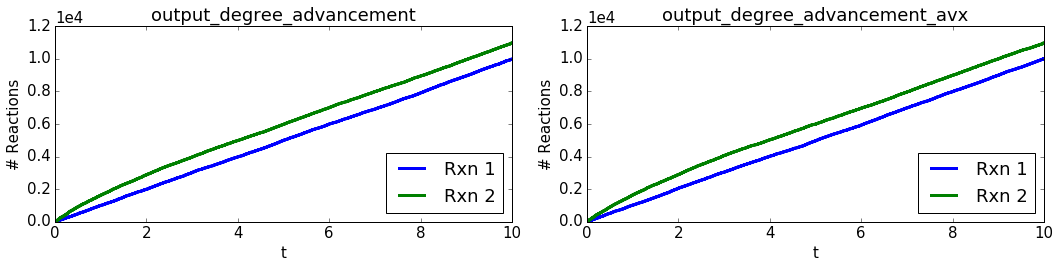

In [125]:
# Plot the time series for a single replicate.
cols=2
rows=int(np.ceil(len(testNames)/cols))
matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,4*rows)})

for i,testName in enumerate(testNames):
    testOutputFilename="tmp/%s.lm"%(testName)
    fp = h5py.File(testOutputFilename, "r")
    
    for replicate in (1,):
        counts=np.array(fp["/Simulations/%07d/DegreeAdvancementCounts"%replicate], dtype=double)
        times=np.array(fp["/Simulations/%07d/DegreeAdvancementTimes"%replicate], dtype=double)
        subplot(rows,cols,i+1)
        step(times,counts[:,0], label='Rxn 1',**stepStyles)
        step(times,counts[:,1], label='Rxn 2', **stepStyles)
        xlabel('t'); ylabel('# Reactions'); title("%s"%(testName)); legend(loc="lower right")
    fp.close()
plt.tight_layout()
pass

### Define the tests.

In [126]:
def test_output_degree_advancement(testOutputFilename):
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    k=0
    mSim1=None
    vSim1=None
    mSim2=None
    vSim2=None
    for replicate in replicates:
        dtimes = np.array(fp["/Simulations/%s/DegreeAdvancementTimes"%replicate], dtype=double)
        dcounts = np.array(fp["/Simulations/%s/DegreeAdvancementCounts"%replicate], dtype=double)
        stimes = np.array(fp["/Simulations/%s/SpeciesCountTimes"%replicate], dtype=double)
        scounts = np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        
        # Make sure the the array sizes are correct.
        if dtimes.shape[0] != 1001: raise Exception("incorrect value for shape for degree advancement time data",dtimes.shape,replicate)
        if dcounts.shape[0] != 1001 or dcounts.shape[1] != 2: raise Exception("incorrect value for shape for degree advancement counts data",dcounts.shape,replicate)
        if stimes.shape[0] != 1001: raise Exception("incorrect value for shape for species time data",stimes.shape,replicate)
        if scounts.shape[0] != 1001 or scounts.shape[1] != 1: raise Exception("incorrect value for shape for species counts data",scounts.shape,replicate)
        
        # Make sure that the degree advancements are correct.
        if np.any(2000+dcounts[:,0]-dcounts[:,1] != scounts[:,0]): raise Exception("incorrect degree advancement counts",replicate)
            
        if mSim1 is None:
            k += 1
            mSim1 = dcounts[:,0]
            vSim1 = np.zeros(dcounts.shape[0], dtype=double)
            mSim2 = dcounts[:,1]
            vSim2 = np.zeros(dcounts.shape[0], dtype=double)
        else:
            k += 1
            mSim1 = mSim1 + (dcounts[:,0]-mSim1)/k
            vSim1 = vSim1 + (dcounts[:,0]-mSim1)*(dcounts[:,0]-mSim1)
            mSim2 = mSim2 + (dcounts[:,1]-mSim2)/k
            vSim2 = vSim2 + (dcounts[:,1]-mSim2)*(dcounts[:,1]-mSim2)
            
    vSim1 /= float((k-1))
    vSim2 /= float((k-1))
    
    # Plot the accuracy of the mean and variance.
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,3)})
    ax=plt.subplot(1,2,1)
    plt.plot(dtimes,mSim1, label='Rxn 1', **plotStyles)
    plt.plot(dtimes,mSim2, label='Rxn 2', **plotStyles)
    ax.set_yscale('log'); xlabel('t'); ylabel('E{X(t)}'); title("%s"%(testOutputFilename)); legend(loc="lower right")
    ax=plt.subplot(1,2,2)
    plt.plot(dtimes,vSim1, label='Rxn 1', **plotStyles)
    plt.plot(dtimes,vSim2, label='Rxn 2', **plotStyles)
    ax.set_yscale('log'); xlabel('t'); ylabel('Var{X(t)}'); title("%s"%(testOutputFilename)); legend(loc="lower right")
    fp.close()
    
    # Verify the output.
    value = mSim1[-1]
    if not isclose(value,10000.0,1e-3): raise Exception("incorrect value for reaction 1 mean",value)
    value = vSim1[-1]
    if not isclose(value,10000.0,1e-1): raise Exception("incorrect value for reaction 1 variance",value)
    value = mSim2[-1]
    if not isclose(value,11000.0,1e-3): raise Exception("incorrect value for reaction 2 mean",value)
    value = vSim2[-1]
    if not isclose(value,10000.0,2e-1): raise Exception("incorrect value for reaction 2 variance",value)        

### Run the tests.

[output_degree_advancement]                                  : passed.


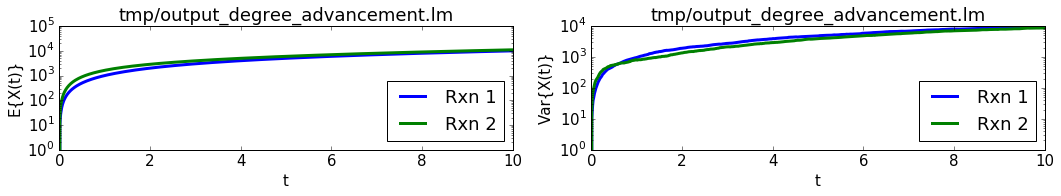

[output_degree_advancement_avx]                              : passed.


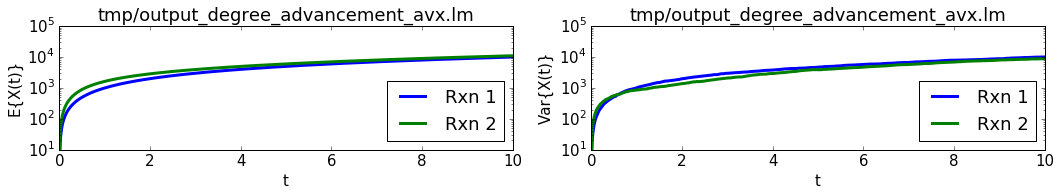

In [127]:
testMethods = {"output_degree_advancement": test_output_degree_advancement,
               "output_degree_advancement_avx": test_output_degree_advancement}
matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (20,5*len(testNames))})
i=1
for testName in testNames:
    try:
        testOutputFilename="tmp/%s.lm"%(testName)
        testMethods[testName](testOutputFilename)
    except Exception as e:
        print "%-60s : FAILED with:"%("["+testName+"]"),e
    except:
        print "%-60s : FAILED with: Unknown exception"%("["+testName+"]")
    else:
        print "%-60s : passed."%("["+testName+"]")
    plt.tight_layout()
    plt.show()
pass

In [128]:
%%bash
rm -rf tmp